# This notebook will compute the bayes factors of mutual exclusivity and co-occurrence under the model:

\begin{equation}
\begin{split}
K = \frac{P(D | M_{A,B})}{P(D) | H_0} = \frac{\int \int \int P(\theta_A, \theta_B, \theta_{A,B}^M | M_{A,B}) P(D| \theta_A, \theta_B, \theta_{A,B}^M , M_{A,B}) d\theta_{A,B}^M d\theta_A d\theta_b }{\int \int \int P(\theta_A, \theta_B, \theta_{A,B}^M | H_0) P(D| \theta_A, \theta_B, \theta_{A,B}^M , H_0) d\theta_{A,B}^M d\theta_A d\theta_b }
\end{split}
\end{equation}

where we assume uniform priors on $\theta_A $ and $\theta_B$:
$ P(\theta_A \in dp | M_{A,B}) = dp$ (since  $\int_0^1 P(\theta_A \in dp | M_{A,B}) dp = 1$)

and
$ P(\theta_B \in dp | M_{A,B}) = dp$ (since  $\int_0^1 P(\theta_B \in dp | M_{A,B}) dp = 1$)

Then, because under $M_{A,B}$, $\theta_{A,B}^M$ must be greater than the value inferred by independence:

\[ P(\theta_{A,B}^M \in dp | \theta_A, \theta_B, M_{A,B}) = \begin{cases}
0 & p \leq \theta_A (1 - \theta_B) + \theta_B (1 - \theta_A) \\
\frac{dp}{\int_{\theta_A (1 - \theta_B) + \theta_B (1 - \theta_A)}^1 dp^*} & p > \theta_A (1 - \theta_B) + \theta_B (1 - \theta_A)\\
\end{cases}
\]

Now, the likelihoods:

\begin{equation}
P(D | \theta_A, \theta_B, \theta_{A,B}^M, M_{A,B}) = P(X_A | \theta_A, M_{A,B}) P(X_B | \theta_B, M_{A,B}) P(X_{A,B}^M | \theta_A, \theta_B, \theta_{A,B}^M, M_{A,B})
\end{equation}

All the $X_E \sim Binom(\theta_E)$ for event $E$.


So, $P(X_A | \theta_A, M_{A,B}) = {n \choose X_A} (\theta_A)^{X_A} (1 - \theta_A)^{n - X_A}$

$P(X_B | \theta_B, M_{A,B}) = {n \choose X_B} (\theta_B)^{X_B} (1 - \theta_B)^{n - X_B}$

$P(X_{A,B}^M | \theta_{A,B}^M, M_{A,B}) = {n \choose X_{A,B}^M} (\theta_{A,B}^M)^{X_{A,B}^M} (1 - \theta_{A,B}^M)^{n - X_{A,B}^M}$

In [20]:
from scipy import special
# Let's calculate the top integral



n = 100
x_A = 20
x_B = 30
x_AB = 15

def make_model(n, x_A, x_B, x_AB):
    theta_A = pymc.DiscreteUniform('theta_A', lower=0, upper=1)
    theta_B = pymc.DiscreteUniform('theta_B', lower=0, upper=1)
    
    @pymc.stochastic(dtype=float)
    def theta_AB(value = 0.3, theta_A=0.1, theta_B=0.2):
        """Return log-likelihood of it"""
        if value < theta_A * theta_B or value > 1:
            return -np.inf
        else:
            return -np.log(1 - theta_B*theta_A)

    
    @pymc.deterministic
    def likelihood_A(theta=theta_A, n=n, x=x_A):
        return special.binom(n, x) * np.power(theta,x) * np.power((1- theta), n-x)

    @pymc.deterministic
    def likelihood_B(theta=theta_B, n=n, x=x_B):
        return special.binom(n, x) * np.power(theta,x) * np.power((1- theta), n-x)

    @pymc.deterministic
    def likelihood_AB(theta=theta_AB, n=n, x=x_AB):
        return special.binom(n, x) * np.power(theta,x) * np.power((1- theta), n-x)

# do you have to say the likelihood is a different variable?
# It's conditional. Has it been observed?
# partially, not completely. still needs theta_A, theta_B

 [-----------------100%-----------------] 200 of 200 complete in 0.0 sec<pymc.MCMC.MCMC object at 0x10aabbb10>


KeyError: 'x_A'

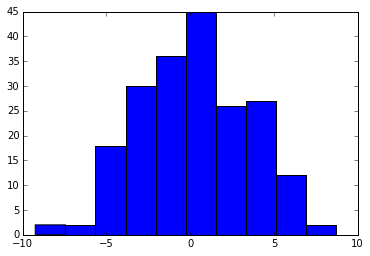

In [28]:
M = pymc.MCMC(make_model(n, x_A, x_B, x_AB))


M.sample(200)
print M.value
plt.hist(M.trace('x')[:])
plt.hist(M.trace('x_A')[:])

In [3]:
import numpy as np
import pymc
import scipy.optimize as opt
import scipy.stats as stats

sigma = 1.0
tau = 1/ sigma**2

sigma0 = 3.0
tau0 = 1/sigma0**2

mu = pymc.Normal("mu", mu=0, tau=tau0)
x = pymc.Normal("x", mu=mu, tau=tau) # a bunch of samples for x
mcmc = pymc.MCMC([mu, x])
mcmc.sample(50000, 10000, 1) #1 is thinning. Results in autocorrelation , serial dependent
# First set burn=0, thin = 1, examine traces

 [-----------------100%-----------------] 50000 of 50000 complete in 2.8 sec

In [4]:
x_samples = mcmc.trace("x")[:]
mu_samples = mcmc.trace("mu")[:]

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


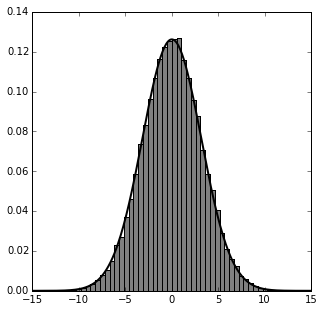

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(5,5))
axes = fig.add_subplot(111)
axes.hist(x_samples, bins=50, normed=True, color="gray");
x_range = np.arange(-15, 15, 0.1)
x_precision = tau * tau0 / (tau + tau0)
axes.plot(x_range, stats.norm.pdf(x_range, 0, 1 / np.sqrt(x_precision)), color='k', linewidth=2);
fig.show()

In [13]:
x_pdf = stats.kde.gaussian_kde(x_samples)

def bayes_factor_sim(x_obs, x_pdf):
    return x_pdf.evaluate(x_obs) / stats.norm.pdf(x_obs, 0, sigma)

def bayes_factor_exact(x_obs):
    return np.sqrt(tau0 / (tau + tau0)) * np.exp(0.5 * tau**2 / (tau + tau0) * x_obs**2)

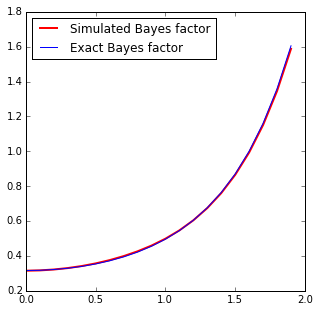

In [14]:
fig = plt.figure(figsize=(5,5))
axes = fig.add_subplot(111)
x_range = np.arange(0, 2, 0.1)
axes.plot(x_range, bayes_factor_sim(x_range, x_pdf), color="red", label="Simulated Bayes factor", linewidth=2)
axes.plot(x_range, bayes_factor_exact(x_range), color="blue", label="Exact Bayes factor")
axes.legend(loc=2)
fig.show()